In [2]:
import numpy as np
import itertools
import hashlib
import math

In [351]:
def read_data(n, k, filename=None
             ):
    chs = np.zeros((k, n), dtype=np.int8)
    rsps = np.zeros(k, dtype=np.int8)
    
    with open(filename or 'data/hashed/Base{}.txt'.format(n), 'r') as f:
        for i, line in enumerate(itertools.islice(f, k)):
            ch, rsp = line.split(' ')
            for j, e in enumerate(ch):
                chs[i, j] = int(e)
            rsps[i] = int(rsp)
            
    return chs, rsps

def to_signed(x):
    p = np.zeros_like(x, dtype=np.int8)
    x = 1 - 2 * x
    
    p[0] = x[0]
    for i in range(1, len(x)):
        p[i] = p[i - 1] * x[i]
    return p

In [352]:
data = {
    "hashed": {},
    "signed": {}
}

In [354]:
for n in range(8, 129, 8):
    data['hashed'][n] = read_data(n, 10 ** 5)
    print(n)

8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128


In [355]:
for n in range(8, 129, 8):
    x, y = data['hashed'][n]
    data['signed'][n] = ([to_signed(e) for e in x], y)
    print(n)

8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128


In [356]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def train_model(model):
    accuracy = {}
    
    for n in range(8, 129, 8):
        x, y = data['signed'][n]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)
        
        m = model()
        m.fit(x_train, y_train)

        y_pred = m.predict(x_test)
        accuracy[n] = accuracy_score(y_test, y_pred)
        print(n)
    
    return accuracy

In [357]:
models = {}

In [358]:
models['Logistic Regression'] = train_model(LogisticRegression)

8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128


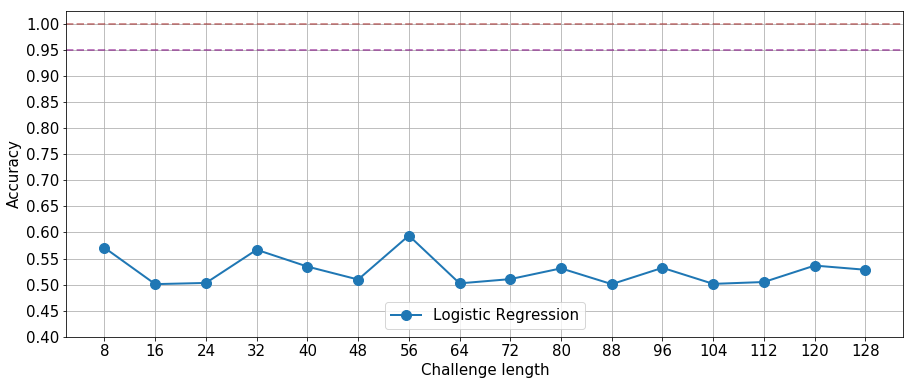

In [421]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 15
plt.rcParams['font.weight'] = 100

fig, ax = plt.subplots()
fig.set_size_inches(15, 6)

for (model_name, result), marker in zip(models.items(), ['o', 's', '^']):
    ax.plot(
        result.keys(), 
        result.values(), 
        '-{}'.format(marker), 
        markersize=10, 
        label=model_name, 
        linewidth=2
    )
    ax.set_xticks(list(result.keys()))
    ax.set_xticklabels(list(result.keys()))

ax.axhline(1, ls='--', color='brown', linewidth=2, alpha=0.5)
ax.axhline(0.95, ls='--', color='purple', linewidth=2, alpha=0.5)
    
ax.set(xlabel='Challenge length', ylabel='Accuracy')
ax.set_yticks(np.arange(0.4, 1.01, 0.05))
    
ax.grid()
ax.legend(loc='lower center')
plt.show()

In [285]:
def to_hashed(x, little_endian=True, reversed_input=False, reversed_output=False):
    endian = 'little' if little_endian else 'big'
    x = x[::-1] if reversed_input else x
    
    s = int(''.join(str(a) for a in x), base=2).to_bytes(len(x), endian)
    s = hashlib.sha256(s).digest()
    s = bin(int.from_bytes(s, endian))[2:].rjust(256, '0')
    
    rv = np.array([int(a) for a in s])
    rv = rv[::-1] if reversed_output else rv
    return rv

In [375]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def count_y(x, w):
    n = x.shape[1]
    
    params = np.round(w[:3])
    hash_params = (bool(params[0]), bool(params[1]), bool(params[2]))
    x = np.array([to_hashed(e, *hash_params) for e in x])
    
    start = int(np.round(sigmoid(w[3] * 5) * (255 - n)))
    x = np.array([e[start:start + n] for e in x])
    
    w, b = w[4:4 + n], w[4 + n]
    x = np.array([to_signed(e) for e in x])
    return np.round(sigmoid(np.dot(x, w) + b))

def fitness(x, y, w):
    y_pred = count_y(x, w)
    return np.sum((y_pred - y) ** 2)

In [376]:
n = 64
x, y = data['hashed'][64]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.9)

In [378]:
import cma
import functools

es = cma.CMAEvolutionStrategy(np.zeros(3 + 1 + n + 1), 1)

(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 69 (seed=347299, Fri Dec  7 22:08:53 2018)


In [379]:
es = es.optimize(functools.partial(fitness, x_train, y_train), iterations=1000)

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 4.922000000000000e+03 1.0e+00 9.55e-01  1e+00  1e+00 1:23.5
    2     32 4.911000000000000e+03 1.0e+00 9.19e-01  9e-01  9e-01 2:41.6
    3     48 4.917000000000000e+03 1.0e+00 8.94e-01  9e-01  9e-01 4:07.0
    4     64 4.869000000000000e+03 1.0e+00 8.70e-01  9e-01  9e-01 5:30.1
    5     80 4.889000000000000e+03 1.1e+00 8.50e-01  8e-01  9e-01 6:48.4
    6     96 4.898000000000000e+03 1.1e+00 8.31e-01  8e-01  8e-01 8:03.3
    7    112 4.869000000000000e+03 1.1e+00 8.17e-01  8e-01  8e-01 9:26.0
    8    128 4.936000000000000e+03 1.1e+00 8.04e-01  8e-01  8e-01 10:47.1
    9    144 4.944000000000000e+03 1.1e+00 7.91e-01  8e-01  8e-01 11:48.0
   10    160 4.940000000000000e+03 1.1e+00 7.79e-01  8e-01  8e-01 12:48.6
   11    176 4.860000000000000e+03 1.1e+00 7.69e-01  8e-01  8e-01 13:50.5
   12    192 4.845000000000000e+03 1.1e+00 7.62e-01  8e-01  8e-01 14:51.8
   13    208 4.907000000000000e+03 1.1e+00 7.59

  160   2560 4.705000000000000e+03 2.0e+00 9.87e-01  8e-01  1e+00 172:14.7
  162   2592 4.683000000000000e+03 2.0e+00 9.95e-01  8e-01  1e+00 174:17.9
  164   2624 4.672000000000000e+03 2.0e+00 9.91e-01  8e-01  1e+00 176:20.3
  166   2656 4.656000000000000e+03 2.0e+00 9.89e-01  8e-01  1e+00 178:22.4
  168   2688 4.665000000000000e+03 2.0e+00 9.84e-01  8e-01  1e+00 180:25.1
  170   2720 4.686000000000000e+03 2.0e+00 9.77e-01  8e-01  1e+00 182:29.4
  172   2752 4.687000000000000e+03 2.0e+00 9.65e-01  8e-01  1e+00 184:36.2
  174   2784 4.703000000000000e+03 2.0e+00 9.54e-01  8e-01  1e+00 186:43.3
  176   2816 4.692000000000000e+03 2.1e+00 9.54e-01  8e-01  1e+00 188:49.8
  178   2848 4.690000000000000e+03 2.1e+00 9.55e-01  8e-01  1e+00 190:56.4
  180   2880 4.702000000000000e+03 2.1e+00 9.57e-01  8e-01  1e+00 193:03.0
  182   2912 4.696000000000000e+03 2.1e+00 9.55e-01  8e-01  1e+00 195:09.5
  184   2944 4.713000000000000e+03 2.1e+00 9.38e-01  8e-01  1e+00 197:15.5
  186   2976 4.6980000000

KeyboardInterrupt: 

In [380]:
y_pred = np.round(count_y(x_test, es.best.x))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.5001444444444444
[[24050 21482]
 [23505 20963]]


In [415]:
s = """1  5  4.922000000000000e+03 1.0e+00 9.55e-01  1e+00  1e+00 1:23.5
    2     32 4.911000000000000e+03 1.0e+00 9.19e-01  9e-01  9e-01 2:41.6
    3     48 4.917000000000000e+03 1.0e+00 8.94e-01  9e-01  9e-01 4:07.0
    4     64 4.869000000000000e+03 1.0e+00 8.70e-01  9e-01  9e-01 5:30.1
    5     80 4.889000000000000e+03 1.1e+00 8.50e-01  8e-01  9e-01 6:48.4
    6     96 4.898000000000000e+03 1.1e+00 8.31e-01  8e-01  8e-01 8:03.3
    7    112 4.869000000000000e+03 1.1e+00 8.17e-01  8e-01  8e-01 9:26.0
    8    128 4.936000000000000e+03 1.1e+00 8.04e-01  8e-01  8e-01 10:47.1
    9    144 4.944000000000000e+03 1.1e+00 7.91e-01  8e-01  8e-01 11:48.0
   10    160 4.940000000000000e+03 1.1e+00 7.79e-01  8e-01  8e-01 12:48.6
   11    176 4.860000000000000e+03 1.1e+00 7.69e-01  8e-01  8e-01 13:50.5
   12    192 4.845000000000000e+03 1.1e+00 7.62e-01  8e-01  8e-01 14:51.8
   13    208 4.907000000000000e+03 1.1e+00 7.59e-01  8e-01  8e-01 15:53.5
   14    224 4.909000000000000e+03 1.1e+00 7.57e-01  8e-01  8e-01 16:54.5
   15    240 4.879000000000000e+03 1.1e+00 7.52e-01  7e-01  8e-01 17:55.2
   16    256 4.829000000000000e+03 1.1e+00 7.49e-01  7e-01  8e-01 18:56.1
   17    272 4.886000000000000e+03 1.1e+00 7.44e-01  7e-01  8e-01 19:59.0
   18    288 4.830000000000000e+03 1.1e+00 7.41e-01  7e-01  8e-01 21:01.5
   19    304 4.881000000000000e+03 1.1e+00 7.38e-01  7e-01  8e-01 22:08.4
   20    320 4.851000000000000e+03 1.1e+00 7.39e-01  7e-01  8e-01 23:10.5
   21    336 4.846000000000000e+03 1.1e+00 7.37e-01  7e-01  8e-01 24:13.9
   22    352 4.837000000000000e+03 1.2e+00 7.34e-01  7e-01  7e-01 25:13.8
   23    368 4.853000000000000e+03 1.2e+00 7.29e-01  7e-01  7e-01 26:16.5
   24    384 4.860000000000000e+03 1.2e+00 7.29e-01  7e-01  7e-01 27:16.4
   25    400 4.885000000000000e+03 1.2e+00 7.31e-01  7e-01  7e-01 28:16.1
   26    416 4.838000000000000e+03 1.2e+00 7.30e-01  7e-01  7e-01 29:17.4
   27    432 4.854000000000000e+03 1.2e+00 7.31e-01  7e-01  7e-01 30:17.9
   28    448 4.888000000000000e+03 1.2e+00 7.29e-01  7e-01  7e-01 31:18.5
   29    464 4.854000000000000e+03 1.2e+00 7.31e-01  7e-01  7e-01 32:18.4
   30    480 4.917000000000000e+03 1.2e+00 7.34e-01  7e-01  8e-01 33:20.6
   31    496 4.911000000000000e+03 1.2e+00 7.38e-01  7e-01  8e-01 34:23.4
   32    512 4.868000000000000e+03 1.2e+00 7.41e-01  7e-01  8e-01 35:43.1
   33    528 4.860000000000000e+03 1.2e+00 7.41e-01  7e-01  8e-01 36:57.0
   34    544 4.861000000000000e+03 1.3e+00 7.40e-01  7e-01  8e-01 38:00.5
   35    560 4.872000000000000e+03 1.3e+00 7.42e-01  7e-01  8e-01 39:04.6
   36    576 4.890000000000000e+03 1.3e+00 7.44e-01  7e-01  8e-01 40:09.2
   37    592 4.886000000000000e+03 1.3e+00 7.49e-01  7e-01  8e-01 41:13.9
   38    608 4.869000000000000e+03 1.3e+00 7.54e-01  7e-01  8e-01 42:18.5
   39    624 4.858000000000000e+03 1.3e+00 7.59e-01  7e-01  8e-01 43:24.0
   40    640 4.851000000000000e+03 1.3e+00 7.57e-01  7e-01  8e-01 44:28.2
   41    656 4.854000000000000e+03 1.3e+00 7.52e-01  7e-01  8e-01 45:32.4
   42    672 4.834000000000000e+03 1.3e+00 7.49e-01  7e-01  8e-01 46:37.8
   43    688 4.835000000000000e+03 1.3e+00 7.42e-01  7e-01  8e-01 47:40.4
   44    704 4.840000000000000e+03 1.3e+00 7.35e-01  7e-01  8e-01 48:41.9
   45    720 4.869000000000000e+03 1.4e+00 7.29e-01  7e-01  8e-01 49:43.6
   46    736 4.870000000000000e+03 1.4e+00 7.21e-01  7e-01  7e-01 50:44.1
   47    752 4.847000000000000e+03 1.4e+00 7.14e-01  7e-01  7e-01 51:48.3
   48    768 4.845000000000000e+03 1.4e+00 7.10e-01  7e-01  7e-01 52:51.3
   49    784 4.851000000000000e+03 1.4e+00 7.07e-01  7e-01  7e-01 53:54.6
   50    800 4.836000000000000e+03 1.4e+00 7.08e-01  7e-01  7e-01 54:58.5
   51    816 4.841000000000000e+03 1.4e+00 7.11e-01  7e-01  7e-01 56:01.7
   52    832 4.828000000000000e+03 1.4e+00 7.14e-01  7e-01  7e-01 57:03.7
   53    848 4.817000000000000e+03 1.4e+00 7.24e-01  7e-01  7e-01 58:05.8
   54    864 4.852000000000000e+03 1.4e+00 7.32e-01  7e-01  8e-01 59:08.6
   55    880 4.868000000000000e+03 1.4e+00 7.42e-01  7e-01  8e-01 60:12.0
   56    896 4.825000000000000e+03 1.4e+00 7.58e-01  7e-01  8e-01 61:14.8
   57    912 4.819000000000000e+03 1.4e+00 7.70e-01  7e-01  8e-01 62:11.5
   58    928 4.802000000000000e+03 1.4e+00 7.82e-01  7e-01  8e-01 63:08.7
   60    960 4.802000000000000e+03 1.5e+00 7.97e-01  8e-01  8e-01 65:02.9
   62    992 4.822000000000000e+03 1.5e+00 8.06e-01  8e-01  8e-01 67:03.6
   64   1024 4.801000000000000e+03 1.5e+00 8.12e-01  8e-01  8e-01 68:60.0
   66   1056 4.796000000000000e+03 1.5e+00 8.04e-01  8e-01  8e-01 70:53.4
   68   1088 4.798000000000000e+03 1.5e+00 7.92e-01  7e-01  8e-01 73:01.1
   69   1104 4.793000000000000e+03 1.5e+00 7.90e-01  7e-01  8e-01 74:18.3
   70   1120 4.802000000000000e+03 1.5e+00 7.86e-01  7e-01  8e-01 75:33.8
   71   1136 4.773000000000000e+03 1.5e+00 7.83e-01  7e-01  8e-01 76:58.7
   73   1168 4.802000000000000e+03 1.5e+00 7.79e-01  7e-01  8e-01 79:02.8
   75   1200 4.780000000000000e+03 1.5e+00 7.93e-01  7e-01  8e-01 81:09.2
   77   1232 4.782000000000000e+03 1.6e+00 8.10e-01  7e-01  8e-01 83:14.2
   79   1264 4.805000000000000e+03 1.6e+00 8.21e-01  8e-01  8e-01 85:20.4
   81   1296 4.760000000000000e+03 1.6e+00 8.22e-01  8e-01  9e-01 87:25.7
   83   1328 4.778000000000000e+03 1.6e+00 8.22e-01  8e-01  9e-01 89:27.4
   85   1360 4.749000000000000e+03 1.6e+00 8.27e-01  8e-01  9e-01 91:27.8
   87   1392 4.759000000000000e+03 1.6e+00 8.25e-01  8e-01  9e-01 93:30.7
   89   1424 4.761000000000000e+03 1.6e+00 8.15e-01  7e-01  8e-01 95:31.0
   91   1456 4.754000000000000e+03 1.6e+00 8.07e-01  7e-01  8e-01 97:34.4
   93   1488 4.765000000000000e+03 1.6e+00 8.02e-01  7e-01  8e-01 99:37.0
   95   1520 4.743000000000000e+03 1.6e+00 7.99e-01  7e-01  8e-01 101:38.1
   97   1552 4.761000000000000e+03 1.6e+00 7.95e-01  7e-01  8e-01 103:41.4
   99   1584 4.780000000000000e+03 1.6e+00 7.97e-01  7e-01  8e-01 105:43.1
  100   1600 4.753000000000000e+03 1.6e+00 7.99e-01  7e-01  8e-01 106:44.5
  102   1632 4.764000000000000e+03 1.6e+00 8.09e-01  7e-01  8e-01 108:46.6
  104   1664 4.762000000000000e+03 1.6e+00 8.18e-01  7e-01  9e-01 110:51.0
  106   1696 4.763000000000000e+03 1.7e+00 8.30e-01  7e-01  9e-01 112:55.9
  108   1728 4.782000000000000e+03 1.7e+00 8.50e-01  8e-01  9e-01 115:05.8
  110   1760 4.760000000000000e+03 1.7e+00 8.81e-01  8e-01  9e-01 117:11.0
  112   1792 4.761000000000000e+03 1.7e+00 9.16e-01  8e-01  1e+00 119:16.1
  114   1824 4.744000000000000e+03 1.7e+00 9.43e-01  8e-01  1e+00 121:19.1
  116   1856 4.741000000000000e+03 1.7e+00 9.76e-01  9e-01  1e+00 123:27.3
  118   1888 4.920000000000000e+03 1.7e+00 1.01e+00  9e-01  1e+00 125:47.3
  120   1920 4.722000000000000e+03 1.8e+00 1.04e+00  9e-01  1e+00 127:59.2
  122   1952 4.770000000000000e+03 1.8e+00 1.04e+00  9e-01  1e+00 130:09.2
  124   1984 4.743000000000000e+03 1.8e+00 1.03e+00  9e-01  1e+00 132:14.0
  126   2016 4.739000000000000e+03 1.8e+00 1.03e+00  9e-01  1e+00 134:36.8
  128   2048 4.748000000000000e+03 1.8e+00 1.04e+00  9e-01  1e+00 136:56.7
  130   2080 4.727000000000000e+03 1.8e+00 1.05e+00  9e-01  1e+00 139:29.1
  132   2112 4.695000000000000e+03 1.8e+00 1.05e+00  9e-01  1e+00 141:55.0
  134   2144 4.714000000000000e+03 1.8e+00 1.04e+00  9e-01  1e+00 144:06.0
  136   2176 4.706000000000000e+03 1.8e+00 1.02e+00  9e-01  1e+00 146:41.6
  138   2208 4.696000000000000e+03 1.9e+00 1.02e+00  9e-01  1e+00 149:05.1
  140   2240 4.703000000000000e+03 1.9e+00 1.03e+00  9e-01  1e+00 151:09.3
  142   2272 4.731000000000000e+03 1.9e+00 1.02e+00  9e-01  1e+00 153:19.4
  144   2304 4.718000000000000e+03 1.9e+00 9.95e-01  8e-01  1e+00 155:31.2
  146   2336 4.720000000000000e+03 1.9e+00 9.87e-01  8e-01  1e+00 157:40.2
  148   2368 4.711000000000000e+03 1.9e+00 9.84e-01  8e-01  1e+00 159:45.0
  150   2400 4.695000000000000e+03 1.9e+00 9.86e-01  8e-01  1e+00 161:49.7
  152   2432 4.698000000000000e+03 1.9e+00 9.80e-01  8e-01  1e+00 163:52.1
  154   2464 4.717000000000000e+03 2.0e+00 9.68e-01  8e-01  1e+00 165:53.6
  156   2496 4.696000000000000e+03 2.0e+00 9.62e-01  8e-01  1e+00 168:02.0
  158   2528 4.676000000000000e+03 2.0e+00 9.73e-01  8e-01  1e+00 170:10.4
  160   2560 4.705000000000000e+03 2.0e+00 9.87e-01  8e-01  1e+00 172:14.7
  162   2592 4.683000000000000e+03 2.0e+00 9.95e-01  8e-01  1e+00 174:17.9
  164   2624 4.672000000000000e+03 2.0e+00 9.91e-01  8e-01  1e+00 176:20.3
  166   2656 4.656000000000000e+03 2.0e+00 9.89e-01  8e-01  1e+00 178:22.4
  168   2688 4.665000000000000e+03 2.0e+00 9.84e-01  8e-01  1e+00 180:25.1
  170   2720 4.686000000000000e+03 2.0e+00 9.77e-01  8e-01  1e+00 182:29.4
  172   2752 4.687000000000000e+03 2.0e+00 9.65e-01  8e-01  1e+00 184:36.2
  174   2784 4.703000000000000e+03 2.0e+00 9.54e-01  8e-01  1e+00 186:43.3
  176   2816 4.692000000000000e+03 2.1e+00 9.54e-01  8e-01  1e+00 188:49.8
  178   2848 4.690000000000000e+03 2.1e+00 9.55e-01  8e-01  1e+00 190:56.4
  180   2880 4.702000000000000e+03 2.1e+00 9.57e-01  8e-01  1e+00 193:03.0
  182   2912 4.696000000000000e+03 2.1e+00 9.55e-01  8e-01  1e+00 195:09.5
  184   2944 4.713000000000000e+03 2.1e+00 9.38e-01  8e-01  1e+00 197:15.5
  186   2976 4.698000000000000e+03 2.1e+00 9.15e-01  7e-01  1e+00 199:21.8
  188   3008 4.700000000000000e+03 2.1e+00 8.86e-01  7e-01  9e-01 201:43.0
  190   3040 4.693000000000000e+03 2.1e+00 8.74e-01  7e-01  9e-01 204:06.7
  192   3072 4.677000000000000e+03 2.1e+00 8.64e-01  7e-01  9e-01 206:16.7
  194   3104 4.674000000000000e+03 2.1e+00 8.61e-01  7e-01  9e-01 208:24.9
  196   3136 4.668000000000000e+03 2.1e+00 8.55e-01  7e-01  9e-01 210:33.9
  199   3184 4.678000000000000e+03 2.1e+00 8.47e-01  7e-01  9e-01 213:47.0
  200   3200 4.675000000000000e+03 2.1e+00 8.40e-01  7e-01  9e-01 214:55.8
  202   3232 4.674000000000000e+03 2.1e+00 8.32e-01  7e-01  9e-01 217:15.8
  205   3280 4.687000000000000e+03 2.1e+00 8.16e-01  6e-01  9e-01 220:24.8
  207   3312 4.674000000000000e+03 2.1e+00 8.02e-01  6e-01  9e-01 222:37.9
  210   3360 4.673000000000000e+03 2.1e+00 7.77e-01  6e-01  8e-01 225:55.0
  213   3408 4.676000000000000e+03 2.1e+00 7.79e-01  6e-01  8e-01 229:05.4
  216   3456 4.671000000000000e+03 2.2e+00 7.95e-01  6e-01  9e-01 232:14.6
  219   3504 4.667000000000000e+03 2.2e+00 7.97e-01  6e-01  9e-01 235:28.5
  222   3552 4.651000000000000e+03 2.2e+00 7.81e-01  6e-01  8e-01 238:38.8
  225   3600 4.641000000000000e+03 2.2e+00 7.67e-01  6e-01  8e-01 241:47.4
  227   3632 4.639000000000000e+03 2.2e+00 7.53e-01  6e-01  8e-01 264:53.1
  230   3680 4.645000000000000e+03 2.2e+00 7.31e-01  6e-01  8e-01 268:10.3
  233   3728 4.642000000000000e+03 2.2e+00 7.30e-01  5e-01  8e-01 271:21.8
  236   3776 4.636000000000000e+03 2.2e+00 7.16e-01  5e-01  8e-01 274:28.6
  239   3824 4.638000000000000e+03 2.2e+00 7.11e-01  5e-01  8e-01 277:47.7
  242   3872 4.628000000000000e+03 2.2e+00 7.18e-01  5e-01  8e-01 280:54.4
  245   3920 4.626000000000000e+03 2.3e+00 7.16e-01  5e-01  8e-01 283:56.8
  248   3968 4.635000000000000e+03 2.3e+00 7.13e-01  5e-01  8e-01 287:01.9
  251   4016 4.633000000000000e+03 2.3e+00 7.09e-01  5e-01  8e-01 290:03.0
  254   4064 4.642000000000000e+03 2.3e+00 7.03e-01  5e-01  7e-01 293:05.4
  257   4112 4.628000000000000e+03 2.3e+00 7.03e-01  5e-01  7e-01 296:12.8
  260   4160 4.608000000000000e+03 2.3e+00 7.16e-01  5e-01  8e-01 299:11.7
  263   4208 4.610000000000000e+03 2.3e+00 7.09e-01  5e-01  8e-01 302:25.5
  266   4256 4.602000000000000e+03 2.3e+00 7.02e-01  5e-01  7e-01 305:30.0
  269   4304 4.597000000000000e+03 2.3e+00 6.94e-01  5e-01  7e-01 308:31.6
  272   4352 4.589000000000000e+03 2.3e+00 6.74e-01  5e-01  7e-01 311:35.9
  275   4400 4.594000000000000e+03 2.4e+00 6.44e-01  5e-01  7e-01 314:40.5
  278   4448 4.577000000000000e+03 2.4e+00 6.51e-01  5e-01  7e-01 317:57.3
  281   4496 4.584000000000000e+03 2.4e+00 6.53e-01  5e-01  7e-01 321:11.1
  284   4544 4.580000000000000e+03 2.4e+00 6.47e-01  5e-01  7e-01 324:23.5
  287   4592 4.573000000000000e+03 2.4e+00 6.33e-01  4e-01  7e-01 327:27.4
  290   4640 4.580000000000000e+03 2.4e+00 6.25e-01  4e-01  7e-01 330:37.7
  293   4688 4.574000000000000e+03 2.4e+00 6.10e-01  4e-01  6e-01 333:53.0
  296   4736 4.572000000000000e+03 2.4e+00 5.82e-01  4e-01  6e-01 337:03.1
  299   4784 4.569000000000000e+03 2.4e+00 5.75e-01  4e-01  6e-01 340:14.0
  300   4800 4.575000000000000e+03 2.5e+00 5.73e-01  4e-01  6e-01 341:16.3
  303   4848 4.585000000000000e+03 2.5e+00 5.61e-01  4e-01  6e-01 344:34.4
  306   4896 4.571000000000000e+03 2.5e+00 5.48e-01  4e-01  6e-01 347:45.5
  309   4944 4.558000000000000e+03 2.5e+00 5.36e-01  4e-01  6e-01 350:51.0
  312   4992 4.551000000000000e+03 2.5e+00 5.23e-01  4e-01  6e-01 355:20.3
  315   5040 4.553000000000000e+03 2.5e+00 5.20e-01  4e-01  6e-01 358:38.2
  318   5088 4.554000000000000e+03 2.5e+00 5.09e-01  3e-01  5e-01 361:52.0
  321   5136 4.539000000000000e+03 2.5e+00 5.01e-01  3e-01  5e-01 365:02.5
  324   5184 4.529000000000000e+03 2.5e+00 4.94e-01  3e-01  5e-01 368:11.3
  327   5232 4.535000000000000e+03 2.6e+00 4.92e-01  3e-01  5e-01 371:28.0
  330   5280 4.531000000000000e+03 2.6e+00 4.89e-01  3e-01  5e-01 374:37.1
  333   5328 4.536000000000000e+03 2.6e+00 4.75e-01  3e-01  5e-01 378:05.2
  336   5376 4.530000000000000e+03 2.6e+00 4.65e-01  3e-01  5e-01 381:25.2
  339   5424 4.524000000000000e+03 2.6e+00 4.52e-01  3e-01  5e-01 384:33.0
  342   5472 4.517000000000000e+03 2.6e+00 4.35e-01  3e-01  5e-01 387:41.3
  345   5520 4.528000000000000e+03 2.6e+00 4.12e-01  3e-01  4e-01 391:05.2
  348   5568 4.525000000000000e+03 2.6e+00 3.90e-01  3e-01  4e-01 394:11.6
  352   5632 4.512000000000000e+03 2.6e+00 3.65e-01  2e-01  4e-01 398:09.1
  355   5680 4.511000000000000e+03 2.6e+00 3.46e-01  2e-01  4e-01 401:20.8
  359   5744 4.513000000000000e+03 2.6e+00 3.23e-01  2e-01  3e-01 405:24.4
  363   5808 4.502000000000000e+03 2.6e+00 2.99e-01  2e-01  3e-01 409:23.6
  367   5872 4.499000000000000e+03 2.6e+00 2.86e-01  2e-01  3e-01 413:30.0
  371   5936 4.490000000000000e+03 2.7e+00 2.74e-01  2e-01  3e-01 417:34.5
  375   6000 4.489000000000000e+03 2.7e+00 2.56e-01  2e-01  3e-01 421:38.0
  379   6064 4.489000000000000e+03 2.7e+00 2.41e-01  2e-01  3e-01 425:41.1
  383   6128 4.496000000000000e+03 2.7e+00 2.28e-01  1e-01  2e-01 429:39.5
  387   6192 4.484000000000000e+03 2.7e+00 2.18e-01  1e-01  2e-01 433:40.0"""

In [416]:
logs = [[e.strip() for e in l.split(' ') if e] for l in s.splitlines()]
data = {int(log[0].strip()) - 1: float(log[2].strip()) for log in logs}

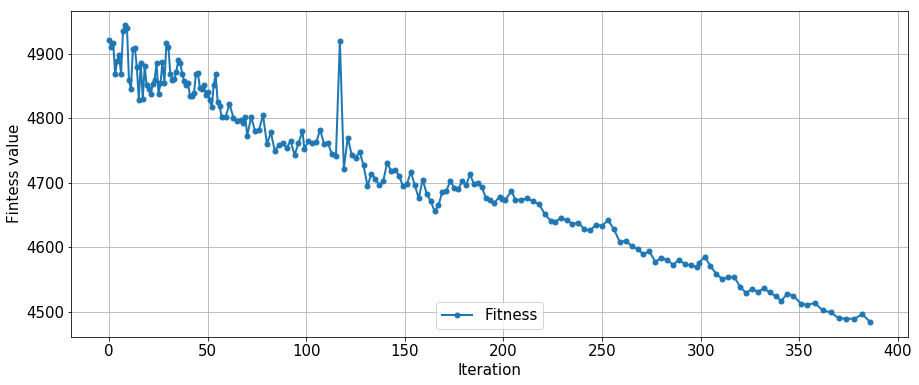

In [422]:
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams['font.size'] = 15
plt.rcParams['font.weight'] = 100

fig = plt.figure()
fig.set_size_inches(15, 6)

ax = fig.add_subplot(1, 1, 1)    
ax.set(xlabel='Iteration', ylabel='Fintess value')
ax.plot(
    data.keys(), 
    data.values(), 
    '-o',
    markersize=5,
    label='Fitness', 
    linewidth=2
)

ax.grid()
ax.legend(loc='lower center')
    
plt.show()